<a href="https://colab.research.google.com/github/sharonshrimp/test/blob/master/cc_fraud.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

欄位說明: https://drive.google.com/file/d/1KkCpMfhFfGfmKehMGD6bIr5Ku-eovlCr/view?usp=sharing


訓練資料集: https://drive.google.com/file/d/1tPGKaWCtoP4UosSUf8j_RPuTIQwDEaJh/view?usp=sharing

# Step1 匯入所需套件與資料

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from sklearn.metrics import recall_score, precision_score, precision_recall_curve
from sklearn.model_selection import train_test_split

In [ ]:
#匯入資料
train_data = pd.read_csv('/content/train.csv')
test_data = "先不給你們"

#查看資料筆數
print("shape of train data:" , train_data.shape)
#print("shape of test data:" , test_data.shape)

#查看表格前五筆資料
train_data.head(5)

shape of train data: (533202, 59)


,TXKEY,DATETIME,CHID,CANO,MCHNO,ACQIC,MCC,CONTP,ETYMD,ECFG,INSFG,ITERM,BNSFG,BNSPT,FLAM1,STOCN,SCITY,OVRLT,PAY_TYPE,FALLBACK_IND,AGNO,CATP1,CUORG,FEEFG,FEDFG,CATP2,TSCFG,LSCFG,CGDCT,APPFG,SAMFG,ANDFG,AGE,CC_CUST_LEVEL,CC_VINTAGE,EDU_CODE,GENDER_CODE,INCOME_RANGE_CODE,MARITAL_STATUS_CODE,NATION_CODE,OCUP_CODE,POSITION_CODE,ACCT_VINTAGE,AVAILABLE_LIMIT_AMT,BONUS_POINTS,CC_PAY_LEVEL_CODE,CREDIT_LIMIT_AMT,CREDIT_REVOLVING_RATE,CREDIT_USE_RATE,CURRENT_CASH_ADV_AMT,CURRENT_FEE,CURRENT_INSTALLMENT_BAL,CURRENT_INSTALLMENT_PURCH_AMT,CURRENT_PURCH_AMT,CURRENT_VIO_AMT,LST_CYCLE_UNPAID_BAL,REVOLVING_AMT,REVOLVING_INTEREST,FRAUD_IND
0,VS0I00120180203AAHPH,2018-02-03 13:52:42,200473230340339563354509,4196756000001,498750000002171,498750,4121,IP,01,1,0,0,0,0,1082.01,nl,help.uber.com,0,NaN,0,0032,VS,F3,0,0,0.0,Y,0,0.0,0,0,0,62.0,B,54.0,5.0,0,1.0,1.0,1.0,11.0,5.0,49.0,385662.0,0.0,1.0,400000.0,0.0,0.0358,0.0,0.0,0.0,0.0,11922.0,0.0,0.0,0.0,0.0,1
1,VS0I00120180203AAHPJ,2018-02-03 13:52:45,200473230340339563354509,4196756000001,498750000002171,498750,4121,IP,01,1,0,0,0,0,2725.35,nl,help.uber.com,0,NaN,0,0032,VS,F3,0,0,0.0,Y,0,0.0,0,0,0,62.0,B,54.0,5.0,0,1.0,1.0,1.0,11.0,5.0,49.0,385662.0,0.0,1.0,400000.0,0.0,0.0358,0.0,0.0,0.0,0.0,11922.0,0.0,0.0,0.0,0.0,1
2,VS0I00120180203AAHRO,2018-02-03 13:56:30,200473230340339563354509,4196756000001,498750000002171,498750,4121,IP,01,1,0,0,0,0,418.38,nl,help.uber.com,0,NaN,0,0032,VS,F3,0,0,0.0,Y,0,0.0,0,0,0,62.0,B,54.0,5.0,0,1.0,1.0,1.0,11.0,5.0,49.0,385662.0,0.0,1.0,400000.0,0.0,0.0358,0.0,0.0,0.0,0.0,11922.0,0.0,0.0,0.0,0.0,1
3,NC0101020170723AAAI7,2017-07-23 02:05:32,900553230371239763056151,3219169000003,8221330004552,429339,5816,IP,01,1,0,0,0,0,239.00,tw,,0,NaN,0,0085,VS,F3,0,0,0.0,Y,0,0.0,0,0,0,41.0,B,85.0,5.0,0,2.0,1.0,1.0,14.0,NaN,73.0,98901.0,13711.0,1.0,250000.0,0.0,0.6044,0.0,669.0,82190.0,14814.0,65631.0,0.0,0.0,0.0,0.0,1
4,NC0100620170823AAAHS,2017-08-23 02:07:28,900553230371239763056151,3219169000003,8221330004552,429339,5816,IP,01,1,0,0,0,0,239.00,tw,,0,NaN,0,0085,VS,F3,0,0,0.0,Y,0,0.0,0,0,0,41.0,B,85.0,5.0,0,2.0,1.0,1.0,14.0,NaN,74.0,117241.0,13920.0,1.0,250000.0,0.0,0.5310,0.0,37.0,101607.0,19697.0,29658.0,0.0,0.0,0.0,0.0,1


In [ ]:
train_data.FRAUD_IND.value_counts()

1.0    49872
Name: FRAUD_IND, dtype: int64

# Step2 EDA (Exploratory Data Analysis)
- 統計數據
- 資料視覺化

## 2-1 統計數據

In [ ]:
#查看基礎統計數據
train_data.describe()

,CANO,ECFG,INSFG,ITERM,BNSFG,BNSPT,FLAM1,OVRLT,FALLBACK_IND,FEEFG,FEDFG,CATP2,LSCFG,CGDCT,APPFG,SAMFG,ANDFG,AGE,CC_VINTAGE,EDU_CODE,GENDER_CODE,INCOME_RANGE_CODE,MARITAL_STATUS_CODE,NATION_CODE,OCUP_CODE,POSITION_CODE,ACCT_VINTAGE,AVAILABLE_LIMIT_AMT,BONUS_POINTS,CC_PAY_LEVEL_CODE,CREDIT_LIMIT_AMT,CREDIT_REVOLVING_RATE,CREDIT_USE_RATE,CURRENT_CASH_ADV_AMT,CURRENT_FEE,CURRENT_INSTALLMENT_BAL,CURRENT_INSTALLMENT_PURCH_AMT,CURRENT_PURCH_AMT,CURRENT_VIO_AMT,LST_CYCLE_UNPAID_BAL,REVOLVING_AMT,REVOLVING_INTEREST,FRAUD_IND
count,5.332020e+05,533202.000000,533202.000000,533202.000000,533202.000000,533202.000000,5.332020e+05,533202.000000,533202.000000,533202.000000,533202.000000,533202.000000,533202.000000,533202.000000,533202.000000,533202.000000,533202.000000,533202.000000,533202.000000,533202.000000,533202.000000,533202.000000,533202.000000,533202.000000,533202.000000,494347.000000,460418.000000,4.604180e+05,4.604180e+05,460329.000000,4.604180e+05,460418.000000,460418.000000,460418.000000,460418.000000,4.604180e+05,460418.000000,4.604180e+05,460418.000000,4.604180e+05,4.604180e+05,460418.000000,533202.000000
mean,2.934265e+12,0.320156,0.023985,0.132406,0.002264,9.671194,2.948112e+03,0.015467,0.004304,0.283808,0.273274,0.061609,0.099079,0.291287,0.103743,0.009595,0.011770,42.259781,112.532414,3.646811,0.467601,1.221171,1.466073,1.001769,10.661346,4.122137,104.158508,1.538994e+05,9.584240e+03,1.250482,2.075423e+05,0.062197,0.276902,131.526606,66.478219,1.298490e+04,3791.029095,3.048889e+04,6.165050,7.014881e+03,8.188252e+03,77.670375,0.143887
std,1.528068e+12,0.466537,0.153003,1.078239,0.047524,888.868698,3.726769e+04,0.123401,0.065465,0.450845,0.445641,0.240444,0.298768,0.569603,0.304927,0.097482,0.107851,10.857415,70.554834,1.206994,0.498950,0.556810,0.500357,0.042017,4.351953,0.922314,70.306938,2.062900e+05,6.530764e+04,0.836664,2.742765e+05,0.191539,0.418543,5036.094475,492.388878,6.349415e+04,14859.931822,1.916603e+05,45.470686,4.568315e+04,7.689639e+04,334.251608,0.350976
min,4.030000e+08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,15.000000,4.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,2.000000,0.000000,-1.054640e+07,-3.025000e+04,0.000000,0.000000e+00,0.000000,0.000000,-260000.000000,-2252.000000,0.000000e+00,-64284.000000,-2.986956e+06,0.000000,-1.174410e+05,0.000000e+00,0.000000,0.000000
25%,1.626222e+12,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,34.000000,54.000000,3.000000,0.000000,1.000000,1.000000,1.000000,7.000000,4.000000,45.000000,5.455400e+04,0.000000e+00,1.000000,1.000000e+05,0.000000,0.047200,0.000000,0.000000,0.000000e+00,0.000000,4.337000e+03,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000
50%,3.239301e+12,0.000000,0.000000,0.000000,0.000000,0.000000,6.600000e+02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,41.000000,92.000000,3.000000,0.000000,1.000000,1.000000,1.000000,11.000000,4.000000,85.000000,1.143680e+05,5.000000e+02,1.000000,1.500000e+05,0.000000,0.151800,0.000000,0.000000,0.000000e+00,0.000000,1.091400e+04,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000
75%,4.180966e+12,1.000000,0.000000,0.000000,0.000000,0.000000,1.610000e+03,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,49.000000,178.000000,5.000000,1.000000,1.000000,2.000000,1.000000,15.000000,5.000000,169.000000,1.957130e+05,3.808000e+03,1.000000,2.500000e+05,0.000000,0.419100,0.000000,2.000000,8.996000e+03,3133.000000,2.509100e+04,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000
max,5.682977e+12,1.000000,1.000000,30.000000,1.000000,515000.000000,1.200000e+07,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000,1.000000,1.000000,91.000000,302.000000,6.000000,1.000000,4.000000,3.000000,2.000000,18.000000,5.0

In [ ]:
#查看各變數空值情況
train_data.count().sort_values().head(20)

PAY_TYPE                          11863
CC_PAY_LEVEL_CODE                460329
AVAILABLE_LIMIT_AMT              460418
ACCT_VINTAGE                     460418
BONUS_POINTS                     460418
CREDIT_LIMIT_AMT                 460418
CREDIT_REVOLVING_RATE            460418
CREDIT_USE_RATE                  460418
REVOLVING_INTEREST               460418
CURRENT_FEE                      460418
CURRENT_INSTALLMENT_BAL          460418
CURRENT_INSTALLMENT_PURCH_AMT    460418
CURRENT_PURCH_AMT                460418
CURRENT_VIO_AMT                  460418
LST_CYCLE_UNPAID_BAL             460418
REVOLVING_AMT                    460418
CURRENT_CASH_ADV_AMT             460418
POSITION_CODE                    494347
CC_CUST_LEVEL                    510561
ANDFG                            533202
dtype: int64

In [ ]:
#查看網路交易註記(ECFG)的冒用比例
train_data.groupby(by='ECFG').mean()['FRAUD_IND']

ECFG
0    0.032864
1    0.379642
Name: FRAUD_IND, dtype: float64

In [ ]:
#查看綁定APPLE PAY註記(APPFG)的冒用比例
train_data.groupby(by='APPFG').mean()['FRAUD_IND']

APPFG
0    0.159498
1    0.009021
Name: FRAUD_IND, dtype: float64

In [ ]:
#查看冒用與非冒用的平均金額
train_data.groupby(by='FRAUD_IND').mean()['FLAM1']

FRAUD_IND
0    2711.539891
1    4355.687942
Name: FLAM1, dtype: float64

## 2-2 資料視覺化
> 以時間相關Features為例

In [ ]:
#新增星期、小時等 Features
train_data["DATETIME"] = train_data["DATETIME"].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))
train_data["WEEKDAY"] = train_data["DATETIME"].apply(lambda x: x.weekday() + 1)
train_data["HOUR"] = train_data["DATETIME"].apply(lambda x: x.hour + 1)

In [ ]:
train_data.groupby(by='WEEKDAY').mean()['FRAUD_IND']

WEEKDAY
1    0.144677
2    0.154192
3    0.151276
4    0.159564
5    0.147093
6    0.125916
7    0.127090
Name: FRAUD_IND, dtype: float64

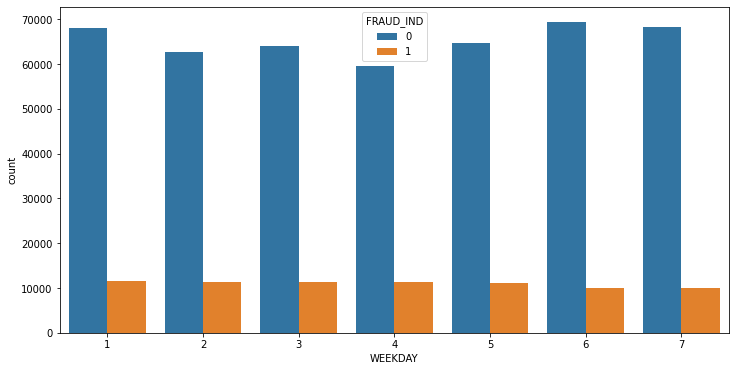

In [ ]:
plt.figure(figsize=(12,6))
sns.countplot(x="WEEKDAY", hue="FRAUD_IND", data=train_data)

In [ ]:
train_data.groupby(by='HOUR').mean()['FRAUD_IND']

HOUR
1     0.365242
2     0.462347
3     0.443151
4     0.517475
5     0.549354
6     0.435051
7     0.265417
8     0.150527
9     0.101270
10    0.086439
11    0.066943
12    0.093055
13    0.093806
14    0.109969
15    0.122815
16    0.131848
17    0.128266
18    0.120261
19    0.105145
20    0.103171
21    0.115246
22    0.149578
23    0.214909
24    0.280281
Name: FRAUD_IND, dtype: float64

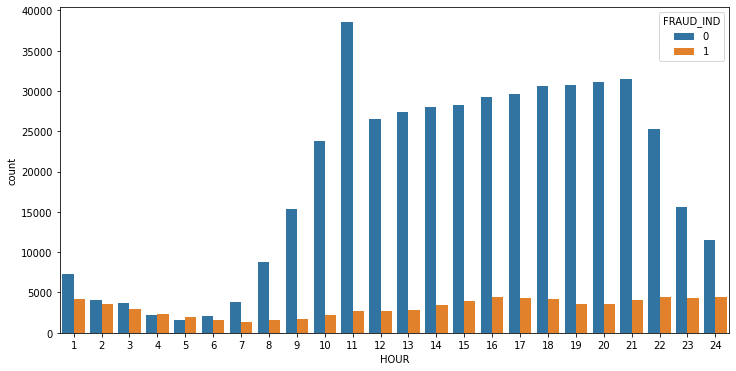

In [ ]:
plt.figure(figsize=(12,6))
sns.countplot(x="HOUR", hue="FRAUD_IND", data=train_data)

延伸閱讀 <br>
- [Pyplot語法教學](https://medium.com/@yuhsuan_chou/python-%E5%9F%BA%E7%A4%8E%E8%B3%87%E6%96%99%E8%A6%96%E8%A6%BA%E5%8C%96-matplotlib-401da7d14e04)
- [Seaborn語法教學](https://leemeng.tw/seaborn-cheat-sheet.html?fbclid=IwAR20VuGkd36AM2TSSQ_eJ7Ct9mC5RA7Y_v_a-mqdLMgYdZdO4pD_cxn0NCc)

## Step3 資料前處理&建模 

- 建模流程<br>
![ml_process.png](https://i.imgur.com/eSK4LVT.png)

### 3-1 資料前處理
1. 空值處理方式

>依照業務邏輯/統計方法選擇補值方式
>- 補0
>- 補中位數 / 平均值 / 眾數
>- 剔除變數
>- 用ML方法補值(容易overfitting)

2. 離群值處理方式

> 透過統計值或盒狀圖檢視有無離群值
>- 補值
>- 另建欄位
>- 剔除變數

In [ ]:
#將所有空值補上
#若資料型態為object，補上"NULL"
#若資料型態為數值，補上-1
train_data[train_data.select_dtypes(include=['object']).columns] = train_data[train_data.select_dtypes(include=['object']).columns].fillna("NULL")
train_data[train_data.select_dtypes(include=['float64', 'int64']).columns] = train_data[train_data.select_dtypes(include=['float64', 'int64']).columns].fillna(-1)

In [ ]:
#將object欄位使用Label Encoder
labelencoder = LabelEncoder()
obj_col = train_data.select_dtypes(include=['object']).columns.to_list()
for col in obj_col:
    train_data[col] = labelencoder.fit_transform(train_data[col])

### 3-2 建立模型
#### 決策樹 Decision Tree

- 決策樹簡介
> 從訓練資料中找出規則，並使每一次切分資料有最大的訊息增益(Information Gain)

![decision_tree.jpeg](https://i.imgur.com/zPfQjxO.jpg)

- LightGBM簡介
> LightGBM是Gradient Boosting Tree的其中一種，而Boosting也是多棵樹集合(Ensemble)的另一種方法。其核心概念是先訓練一棵較簡單的樹，再透過樣本權重分配的方式針對估不準的樣本重新建樹，相較於單一棵決策樹通常有更好的精準度。

![lgbm.png](https://i.imgur.com/GXjkWZD.png)


延伸閱讀 <br>
- [kaggle機器學習競賽神器xgboost介紹](https://medium.com/jameslearningnote/%E8%B3%87%E6%96%99%E5%88%86%E6%9E%90-%E6%A9%9F%E5%99%A8%E5%AD%B8%E7%BF%92-%E7%AC%AC5-2%E8%AC%9B-kaggle%E6%A9%9F%E5%99%A8%E5%AD%B8%E7%BF%92%E7%AB%B6%E8%B3%BD%E7%A5%9E%E5%99%A8xgboost%E4%BB%8B%E7%B4%B9-1c8f55cffcc)
- [《決策樹系列》LightGBM模型理論](https://medium.com/@jimmywu0621/%E6%B1%BA%E7%AD%96%E6%A8%B9%E7%B3%BB%E5%88%97-lightgbm%E6%A8%A1%E5%9E%8B%E7%90%86%E8%AB%96-96ce38ea8940)

In [ ]:
#將資料切分為train&test
df_fraud = train_data[train_data["FRAUD_IND"] == 1]
df_not_fraud = train_data[train_data["FRAUD_IND"] != 1].sample(frac=0.7, random_state=42)
df_train = pd.concat([df_fraud, df_not_fraud], 0)
X = df_train.drop(["FRAUD_IND", "TXKEY", "DATETIME", "CANO", "CHID", "ACQIC", "MCHNO", "AGE"], 1)
y = df_train["FRAUD_IND"]

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=42)
lgb_train = lgb.Dataset(x_train, y_train)
lgb_test = lgb.Dataset(x_test, y_test)

In [ ]:
#設定模型參數
params = {
    "boosting_type": "gbdt",
    "objective": "binary",
    "metric": "binary_logloss",
    "max_depth": 8,
    "learning_rate": 0.05,
    "n_estimators": 1000,
}

In [ ]:
#建立模型
clf = lgb.train(
    params,
    lgb_train,
    num_boost_round=1000,
    valid_sets=[lgb_train, lgb_test],
    early_stopping_rounds=30,
    verbose_eval=50
)

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 30 rounds.
[50]	training's binary_logloss: 0.162279	valid_1's binary_logloss: 0.162807
[100]	training's binary_logloss: 0.134768	valid_1's binary_logloss: 0.136324
[150]	training's binary_logloss: 0.122707	valid_1's binary_logloss: 0.125311
[200]	training's binary_logloss: 0.114838	valid_1's binary_logloss: 0.118302
[250]	training's binary_logloss: 0.108433	valid_1's binary_logloss: 0.112826
[300]	training's binary_logloss: 0.103261	valid_1's binary_logloss: 0.108748
[350]	training's binary_logloss: 0.0987153	valid_1's binary_logloss: 0.104977
[400]	training's binary_logloss: 0.0947501	valid_1's binary_logloss: 0.101738
[450]	training's binary_logloss: 0.0907433	valid_1's binary_logloss: 0.0984731
[500]	training's binary_logloss: 0.0871949	valid_1's binary_logloss: 0.0957686
[550]	training's binary_logloss: 0.0840042	valid_1's binary_logloss: 0.0932831
[600]	training's binary_logloss: 0.0807209	valid_1's binary_logloss: 0.0907092
[650]

### 3-3 模型驗證
本次模型衡量指標為F1-Score

In [ ]:
y_pred = clf.predict(x_test)
precision, recall, threshold = precision_recall_curve(y_test, y_pred)

In [ ]:
performance = {"precision": precision[0:-1],
               "recall": recall[0:-1],
               "threshold": threshold
              }
performance["f1"] = 2 * (performance["precision"] * performance["recall"]) / (performance["precision"] + performance["recall"])
performance = pd.DataFrame(performance)
thr = performance[performance["f1"] == max(performance["f1"])]["threshold"].values[0]

In [ ]:
recall = performance[performance["f1"] == max(performance["f1"])]["recall"].values[0]
precision = performance[performance["f1"] == max(performance["f1"])]["precision"].values[0]
print("Recall Score:", recall)
print("Precision Score:", precision)
print("F1 Score:", 2 * (precision * recall) / (precision + recall))
print("Threshold: ", thr)

Recall Score: 0.9395369122194909
Precision Score: 0.926496461664777
F1 Score: 0.9329711214787691
Threshold:  0.5103514674209937


In [ ]:
importance = {
"col": np.array(x_train.columns),
"imp": lgb.Booster.feature_importance(clf)
}

In [ ]:
df_imp = pd.DataFrame(importance).sort_values(by='imp', ascending=False)
df_imp

,col,imp
27,CC_VINTAGE,2738
0,MCC,2294
10,SCITY,1787
8,FLAM1,1761
37,BONUS_POINTS,1570
9,STOCN,1479
35,ACCT_VINTAGE,1201
36,AVAILABLE_LIMIT_AMT,1199
14,AGNO,1171
43,CURRENT_FEE,1156


In [ ]:
imp_list = df_imp[df_imp["imp"] >= 100].col.to_list()

# Step4 特徵工程及特徵篩選
- 加入交易時間差因子，以及前一個模型的重要特徵!

In [ ]:
def date_diff(df, time_shift):
    df["shift"] = df.groupby(['CHID'])["DATETIME"].shift(time_shift)
    df['CHID_DIF' + str(time_shift)] = (df["DATETIME"] - df['shift']).dt.total_seconds().fillna(0)
    df = df.drop("shift", 1)
    return df

In [ ]:
train_data = date_diff(train_data, 1)
train_data = date_diff(train_data, 2)
train_data = date_diff(train_data, 3)
train_data = date_diff(train_data, 4)
train_data = date_diff(train_data, 5)

In [ ]:
imp_list.append('CHID_DIF1')
imp_list.append('CHID_DIF2')
imp_list.append('CHID_DIF3')
imp_list.append('CHID_DIF4')
imp_list.append('CHID_DIF5')

In [ ]:
#將資料切分為train&test
df_fraud = train_data[train_data["FRAUD_IND"] == 1]
df_not_fraud = train_data[train_data["FRAUD_IND"] != 1].sample(frac=0.7, random_state=42)
df_train = pd.concat([df_fraud, df_not_fraud], 0)
X = df_train[imp_list]
y = df_train["FRAUD_IND"]
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=42)
lgb_train = lgb.Dataset(x_train, y_train)
lgb_test = lgb.Dataset(x_test, y_test)

In [ ]:
clf = lgb.train(
    params,
    lgb_train,
    num_boost_round=1000,
    valid_sets=[lgb_train, lgb_test],
    early_stopping_rounds=30,
    verbose_eval=50
)

/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Training until validation scores don't improve for 30 rounds.
[50]	training's binary_logloss: 0.0988418	valid_1's binary_logloss: 0.0987328
[100]	training's binary_logloss: 0.068943	valid_1's binary_logloss: 0.0702506
[150]	training's binary_logloss: 0.0593797	valid_1's binary_logloss: 0.0619376
[200]	training's binary_logloss: 0.0536572	valid_1's binary_logloss: 0.057108
[250]	training's binary_logloss: 0.0489891	valid_1's binary_logloss: 0.0534217
[300]	training's binary_logloss: 0.0450418	valid_1's binary_logloss: 0.0502751
[350]	training's binary_logloss: 0.041797	valid_1's binary_logloss: 0.0477107
[400]	training's binary_logloss: 0.0386505	valid_1's binary_logloss: 0.0454843
[450]	training's binary_logloss: 0.0357607	valid_1's binary_logloss: 0.0432438
[500]	training's binary_logloss: 0.0331923	valid_1's binary_logloss: 0.0412911
[550]	training's binary_logloss: 0.0308869	valid_1's binary_logloss: 0.0394743
[600]	training's binary_logloss: 0.0290428	valid_1's binary_logloss: 0.03

In [ ]:
y_pred = clf.predict_proba(x_test)
precision, recall, threshold = precision_recall_curve(y_test, y_pred)

In [ ]:
performance = {"precision": precision[0:-1],
               "recall": recall[0:-1],
               "threshold": threshold
              }
performance["f1"] = 2 * (performance["precision"] * performance["recall"]) / (performance["precision"] + performance["recall"])
performance = pd.DataFrame(performance)
thr = performance[performance["f1"] == max(performance["f1"])]["threshold"].values[0]

In [ ]:
recall = performance[performance["f1"] == max(performance["f1"])]["recall"].values[0]
precision = performance[performance["f1"] == max(performance["f1"])]["precision"].values[0]
print("Recall Score:", recall)
print("Precision Score:", precision)
print("F1 Score:", 2 * (precision * recall) / (precision + recall))
print("Threshold: ", thr)

Recall Score: 0.9725636349218936
Precision Score: 0.9783432377457824
F1 Score: 0.975444875236107
Threshold:  0.49328515084712365


## Step5 產製丟到Kaggle的測資

In [ ]:
txkey = test_data["TXKEY"]
test_data["DATETIME"] = test_data["DATETIME"].apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))
test_data["WEEKDAY"] = test_data["DATETIME"].apply(lambda x: x.weekday() + 1)
test_data["HOUR"] = test_data["DATETIME"].apply(lambda x: x.hour + 1)

NameError: ignored

In [ ]:
test_data[test_data.select_dtypes(include=['object']).columns] = test_data[test_data.select_dtypes(include=['object']).columns].fillna("NULL")
test_data[test_data.select_dtypes(include=['float64', 'int64']).columns] = test_data[test_data.select_dtypes(include=['float64', 'int64']).columns].fillna(-1)
obj_col = test_data.select_dtypes(include=['object']).columns.to_list()
for col in obj_col:
    test_data[col] = labelencoder.fit_transform(test_data[col])

NameError: ignored

In [ ]:
test_data = date_diff(test_data, 1)
test_data = date_diff(test_data, 2)
test_data = date_diff(test_data, 3)
test_data = date_diff(test_data, 4)
test_data = date_diff(test_data, 5)

In [ ]:
test_set = test_data[imp_list]

In [ ]:
test_pred = clf.predict_proba(test_set)
test_pred = np.where(test_pred >= thr, 1, 0)

In [ ]:
test_pred.sum()

In [ ]:
submit_dict = {
    "TXKEY": np.array(txkey),
    "FRAUD_IND": test_pred 
}


In [ ]:
submit = pd.DataFrame(submit_dict)

In [ ]:
submit.to_csv("submit.csv", index=False)